# Goal: Given a taxi trip, predict the travel time!

Useful data analysis:
https://www.julienphalip.com/blog/kaggle-competition-report-ecml-pkdd-2015-taxi/

paper on how to develop models:
https://arxiv.org/abs/1508.00021


### General Info

TRIP_ID: (String) - An unique identifier for each trip; \
CALL_TYPE: (char) - Category of the ride. It may contain one of three possible values: \
‘A’ if this trip was dispatched from the central \
‘B’ if this trip was demanded directly to a taxi driver on a specific stand \
‘C’ otherwise (i.e. a trip demanded on a random street \
ORIGIN_CALL: (integer) - An unique identifier for the phone number to call the taxi. It identifies the trip’s customer \ 
if CALL_TYPE=’A’. Otherwise, it assumes a NULL value; \
ORIGIN_STAND: (integer) - An unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE=’B’. Otherwise, it assumes a NULL value; \
TAXI_ID: (integer) - An unique identifier for the taxi that performed each trip; \
TIMESTAMP: (integer) - Unix Timestamp (in seconds). It identifies the trip’s start; \
DAYTYPE: (char) - It identifies the daytype of the trip’s start. It assumes one of three possible values: \
‘A’ if this trip started on a normal day or weekend \
‘B’ if this trip started on a holiday or other special day \
‘C’ if the trip started on a day before a type-B day \
MISSING_DATA: (Boolean) - It is FALSE when the GPS data stream is complete and TRUE whenever one (or more) locations are missing \
POLYLINE: (String): - A list of GPS coordinates (i.e. WGS84 format) mapped as a string. The beginning and the end of the string are identified with brackets (i.e. [ and ]). Each pair of coordinates is also identified by the same brackets as [LONGITUDE, LATITUDE]. The coordinates were recorded every 15 seconds during the trip. The first item represents the starting point and the last item corresponds to the destination. \
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch

#https://www.julienphalip.com/blog/kaggle-competition-report-ecml-pkdd-2015-taxi/
import pickle
import csv
import calendar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.ticker import  MultipleLocator, FormatStrFormatterfrom sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv("train.csv")
train

,Unnamed: 0,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,POLYLINE_CT,TRIP_DUR_SEC,START_LONGITUDE,START_LATITUDE,END_LONGITUDE,END_LATITUDE
0,0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",23,345,-8.618643,41.141412,-8.630838,41.154489
1,1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",19,285,-8.639847,41.159826,-8.66574,41.170671
2,2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",65,975,-8.612964,41.140359,-8.61597,41.140530
3,3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",43,645,-8.574678,41.151951,-8.607996,41.142915
4,4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",29,435,-8.645994,41.18049,-8.687268,41.178087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710655,1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",32,480,-8.612469,41.14602,-8.611344,41.171013
1710656,1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",30,450,-8.610138,41.140845,-8.627454,41.158755
1710657,1710667,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,False,[],0,0,0.000000,0,0,0.000000
1710658,1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",62,930,-8.630712,41.154885,-8.587026,41.173524


In [3]:
train_rows = train.shape[0] 

In [4]:
#splitting data 80-10-10 (training-validating-testing)

perm = torch.randperm(train_rows) #return indices from 0 to 1710660
eighty = int(train_rows * 0.80)
ten = int(train_rows * 0.10)
trainning_idx = perm[:eighty]
validate_idx = perm[eighty:eighty + ten]
test_idx = perm[eighty + ten:]
# print(trainning_idx.shape[0] + validate_idx.shape[0] + test_idx.shape[0] == train_rows)

In [5]:
# #you can also split this by doing
# train, validation, train_labels, validation_labels = train_test_split(train, train_labels, test_size=0.02)
# validation, test, validation_labels, test_labels = train_test_split(validation, validation_labels, test_size=0.5)

Polyline: (longitude, latitude) update for every 15 seconds

# Data cleaning... 
Figure out how much each trip ID lasted! \
Using code from discussion

In [6]:
train_no_missing_poly = train[['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'TIMESTAMP', 'DAY_TYPE', 'POLYLINE_CT', 'TRIP_DUR_SEC']]
train_no_missing_poly

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE_CT,TRIP_DUR_SEC
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,23,345
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,19,285
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,65,975
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,43,645
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,29,435
...,...,...,...,...,...,...,...,...,...
1710655,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,32,480
1710656,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,30,450
1710657,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,0,0
1710658,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,62,930


## Exploratory Data Analysis

In [7]:
print(train_no_missing_poly.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710660 entries, 0 to 1710659
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   POLYLINE_CT   int64  
 8   TRIP_DUR_SEC  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 117.5+ MB
None


In [8]:
#find the basic statistical relationships of polyline_ct and trip_dur_sec

In [9]:
poly_ct_sec_stat = train_no_missing_poly[['POLYLINE_CT', 'TRIP_DUR_SEC']].describe()
poly_ct_sec_stat

,POLYLINE_CT,TRIP_DUR_SEC
count,1.710660e+06,1.710660e+06
mean,4.875803e+01,7.313705e+02
std,4.565224e+01,6.847837e+02
min,0.000000e+00,0.000000e+00
25%,2.800000e+01,4.200000e+02
50%,4.100000e+01,6.150000e+02
75%,5.900000e+01,8.850000e+02
max,3.881000e+03,5.821500e+04


In [10]:
def SecToMin(sec):
    min = (sec/60)
    return min 

In [11]:
#mean trip time
SecToMin(7.31e2)

12.183333333333334

In [12]:
#max trip time
SecToMin(5.82e4)

970.0

In [13]:
#with help of https://github.com/jphalip/ECML-PKDD-2015/blob/master/code/utils.py
# Coordinates of Porto's city centre
import copy
from matplotlib.colors import LogNorm
porto = [41.1579, -8.6291]

def density_map(latitudes, longitudes, center=porto, bins=1000, radius=0.1):
    """
    Displays a density map in a matplotlib histogram for all the points
    defined by the given latitudes and longitudes.
    """
    # LogNorm will flag 0-value pixels as "bad" and color them in white.
    # So we tweak the color map to color them in black.
    cmap = copy.copy(plt.cm.jet)
    cmap.set_bad((0,0,0))  # Fill background with black

    # Center the map around the provided center coordinates
    histogram_range = [
        [center[1] - radius, center[1] + radius],
        [center[0] - radius, center[0] + radius]
    ]
    
    plt.figure(figsize=(5,5))
    plt.hist2d(longitudes, latitudes, bins=bins, norm=LogNorm(),
               cmap=cmap, range=histogram_range)

    # Remove all axes and annotations to keep the map clean and simple
    plt.grid('off')
    plt.axis('off')
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)
    plt.tight_layout()
    plt.show()

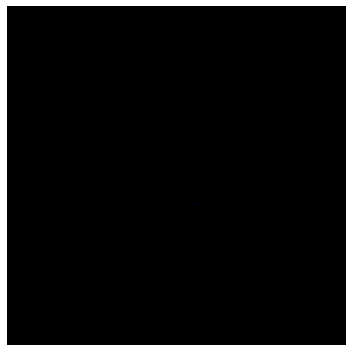

In [14]:
latitude = np.array([41.141412, 41.141376, 41.14251, 41.143815])
longitude = np.array([-8.618643, -8.618499, -8.620326, -8.622153])
density_map(latitude, longitude)

In [15]:
train_no_missing_poly

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,POLYLINE_CT,TRIP_DUR_SEC
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,23,345
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,19,285
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,65,975
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,43,645
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,29,435
...,...,...,...,...,...,...,...,...,...
1710655,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,32,480
1710656,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,30,450
1710657,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,0,0
1710658,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,62,930


In [16]:
train_no_missing_poly.groupby(['TRIP_DUR_SEC', 'TRIP_ID']).mean()

/tmp/ipykernel_1512/2286379532.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_no_missing_poly.groupby(['TRIP_DUR_SEC', 'TRIP_ID']).mean()


ORIGIN_CALL  ORIGIN_STAND     TAXI_ID  \
TRIP_DUR_SEC TRIP_ID                                                      
0            1372665673620000353          NaN           NaN  20000353.0   
             1372665875620000496          NaN           NaN  20000496.0   
             1372667320620000288          NaN           NaN  20000288.0   
             1372669158620000562          NaN           NaN  20000562.0   
             1372676112620000600          NaN           NaN  20000600.0   
...                                       ...           ...         ...   
53565        1375289927620000902          NaN           NaN  20000902.0   
53850        1376892235620000086          NaN           NaN  20000086.0   
57540        1383293324620000520          NaN          13.0  20000520.0   
58080        1400312076620000562          NaN           NaN  20000562.0   
58215        1393061275620000681          NaN           NaN  20000681.0   

                                     TIMESTAMP  POLYLINE_CT  
TRIP_DUR_SEC TRIP_ID                                         
0            1372665673620000353  1.372666e+09          0.0  
             1372665875620000496  1.372666e+09          0.0  
             1372667320620000288  1.372667e+09          0.0  
             1372669158620000562  1.372669e+09          0.0  
             1372676112620000600  1.372676e+09          0.0  
...                                        ...          ...  
53565        1375289927620000902  1.375290e+09       3571.0  
53850        1376892235620000086  1.376892e+09       3590.0  
57540        1383293324620000520  1.383293e+09       3836.0  
58080        1400312076620000562  1.400312e+09       3872.0  
58215        1393061275620000681  1.393061e+09       3881.0  

[1710633 rows x 5 columns]

### Trip_dur_sec ranges from [0, 58215] in 15 sec intervals

Ex) of TRIP_IDS with 0 seconds are: 
- 1372665673620000353
- 1372665875620000496
- 1372667320620000288
- 1372669158620000562	
...

## Focusing on Location and Time

In [25]:
train_loc_dur = train[['TRIP_ID','TIMESTAMP','START_LATITUDE', 'START_LATITUDE', 'END_LATITUDE', 'END_LONGITUDE', 'TRIP_DUR_SEC']]
train_loc_dur

,TRIP_ID,TIMESTAMP,START_LATITUDE,START_LATITUDE,END_LATITUDE,END_LONGITUDE,TRIP_DUR_SEC
0,1372636858620000589,1372636858,41.141412,41.141412,41.154489,-8.630838,345
1,1372637303620000596,1372637303,41.159826,41.159826,41.170671,-8.66574,285
2,1372636951620000320,1372636951,41.140359,41.140359,41.140530,-8.61597,975
3,1372636854620000520,1372636854,41.151951,41.151951,41.142915,-8.607996,645
4,1372637091620000337,1372637091,41.18049,41.18049,41.178087,-8.687268,435
...,...,...,...,...,...,...,...
1710655,1404171463620000698,1404171463,41.14602,41.14602,41.171013,-8.611344,480
1710656,1404171367620000670,1404171367,41.140845,41.140845,41.158755,-8.627454,450
1710657,1388745716620000264,1388745716,0,0,0.000000,0,0
1710658,1404141826620000248,1404141826,41.154885,41.154885,41.173524,-8.587026,930


### Using Linear regression

## Submission Template

In [17]:
# from feature_engineering discussion
## Sample submission file that is given on kaggle
# df_sample = pd.read_csv("sampleSubmission.csv")

# df_sample["TRAVEL_TIME"] = 716.43

# # mean(716.43) -> 792.73593
# # median(600) -> 784.74219
# df_sample.to_csv("my_pred.csv", index=None)